https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

In [18]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 

#for loading and visualizing audio files
import librosa
import librosa.display

#to play audio
import IPython.display as ipd

from scipy.io import wavfile
import numpy as np
from scipy import signal
import scipy.signal as sps
from scipy.signal import butter, lfilter

In [91]:
noisyspeech_fpath = "audio/noisy_speech/SNR_-3/"
noisyspeech_clips = os.listdir(noisyspeech_fpath)

In [52]:
speech_fpath = "audio/test_speech/"
speech_clips = os.listdir(speech_fpath)

In [53]:
POS = os.path.join(speech_fpath)
NEG = os.path.join(noisyspeech_fpath)

In [54]:
pos = tf.data.Dataset.list_files(POS+'*.wav')
neg = tf.data.Dataset.list_files(NEG+'*.wav')

In [55]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [56]:
lengths = []
for file in os.listdir(os.path.join(noisyspeech_fpath)):
    tensor_wave = os.path.join(noisyspeech_fpath, file)
    lengths.append(len(tensor_wave))

In [58]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=40>

In [59]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=40>

In [60]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=41>

In [86]:
def preprocess(file_path, label): 
    file_contents = tf.io.read_file(file_path)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [87]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(filepath)
print(label)

b'audio\\test_speech\\speech_2.wav'
1.0


In [88]:
spectrogram, label = preprocess(filepath, label)

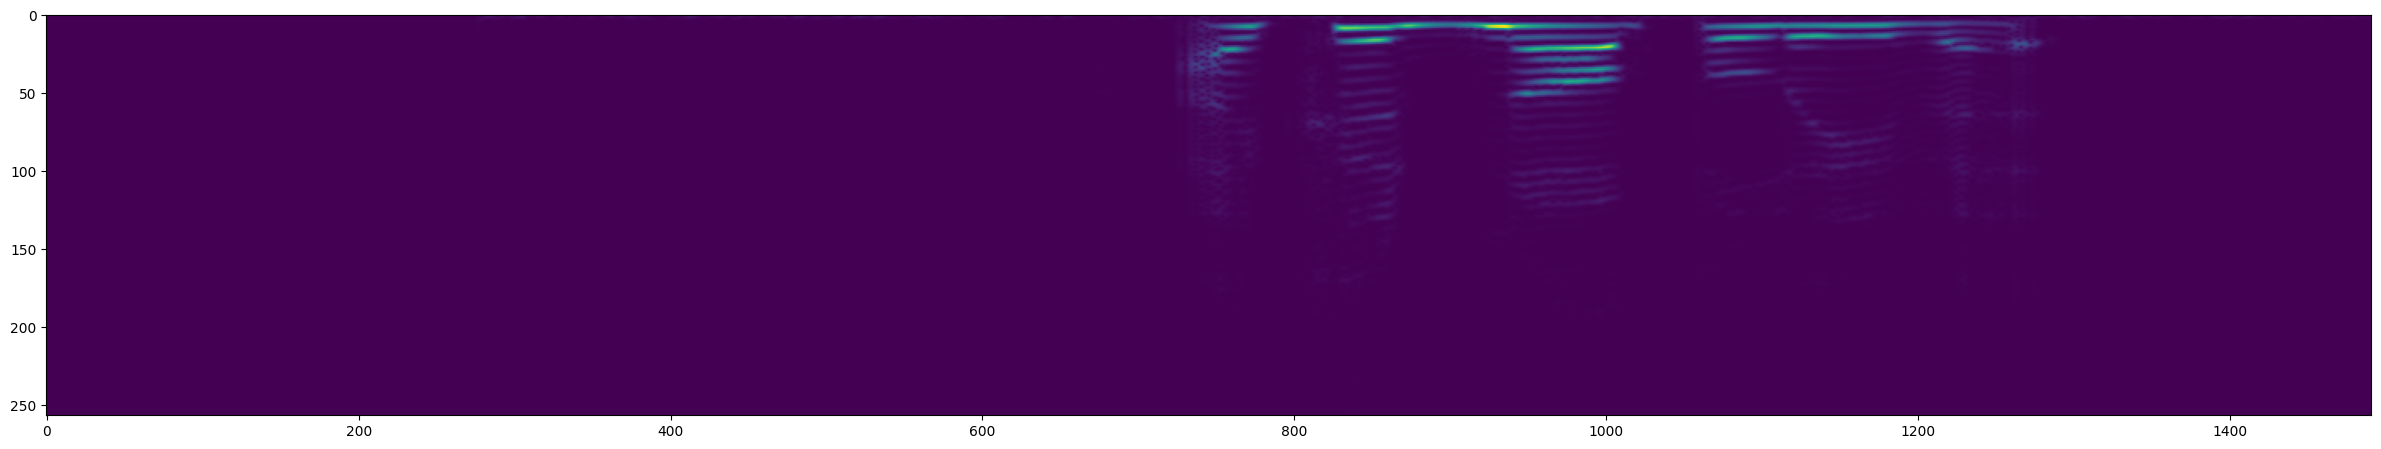

In [89]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [103]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [100]:
samplerate, data = wavfile.read(filepath)
print(filepath)

b'audio\\test_speech\\speech_2.wav'


Text(0.5, 0, 'Time [sec]')

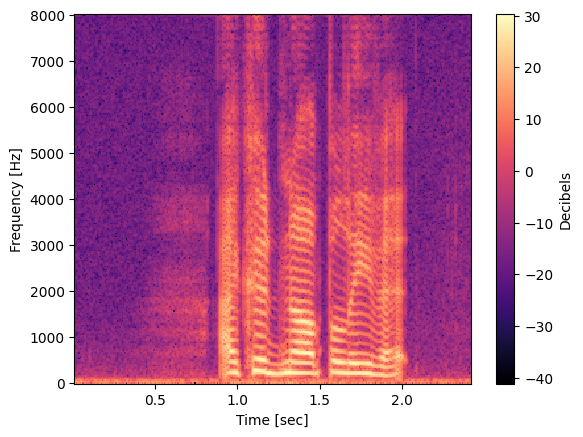

In [ ]:
#Change directories as required
f, t, Lxx = signal.spectrogram(x = data, fs = samplerate, window = 'hann',nperseg = 512,noverlap = 384,nfft = 512,detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='magnitude')
plt.pcolormesh(t, f, 10 * np.log10(Lxx), cmap ='magma')
plt.colorbar(label='Decibels')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')